In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de datos

In [2]:
train_data = pd.read_csv("spaceship-titanic/train.csv")
print(train_data.shape)
train_data.head(3)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


## Valores faltantes

In [13]:
train_data.isna().sum()

PassengerId            0
HomePlanet           201
CryoSleep            217
Cabin                199
Destination          182
Age                  179
VIP                  203
RoomService          181
FoodCourt            183
ShoppingMall         208
Spa                  183
VRDeck               188
Name                 200
Transported            0
PassengerGroup         0
PassengerGroupNum      0
GroupSize              0
dtype: int64

## Valores repetidos y únicos

In [3]:
train_data.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

Cada pasagero tiene un `PassengerId` único, sin embargo hay algunos nombres que se repiten. También, varios pasageros comparten `Cabin`.

## Análisis de correlación

In [14]:
train_data.corr(numeric_only=True).style.background_gradient('viridis')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


# Análisis univariante

## PassengerId

A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. **People in a group are often family members, but not always.**

In [5]:
passengersInfo = train_data.PassengerId.apply( lambda gggg_pp : pd.Series(index=['PassengerGroup','PassengerGroupNum'],
                                                                          data=[gggg_pp.split('_')[0], gggg_pp.split('_')[1]]) )
train_data = train_data.merge(passengersInfo, how='inner', left_index=True, right_index=True)
train_data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNum
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01


In [6]:
train_data.PassengerGroup.min(), train_data.PassengerGroup.max()

('0001', '9280')

In [7]:
train_data.PassengerGroupNum.min(), train_data.PassengerGroupNum.max()

('01', '08')

In [8]:
train_data.loc[ train_data.PassengerGroupNum=='08', 'PassengerGroup' ].unique()

array(['0984', '4005', '4256', '4498', '5133', '5756', '5885', '8168',
       '8728', '8796', '8956', '8988', '9081'], dtype=object)

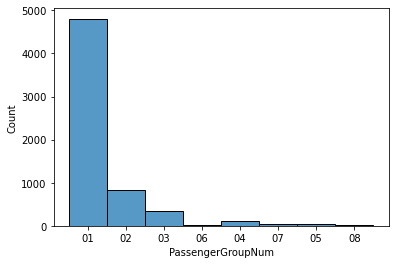

In [9]:
sns.histplot( train_data.groupby('PassengerGroup')['PassengerGroupNum'].max() );

Quizás se pueda extraer una variable que clasifique los grupos en función del tamaño.

In [10]:
group_size = train_data.groupby('PassengerGroup')[['PassengerGroupNum']].max().rename(columns={'PassengerGroupNum':'GroupSize'}).reset_index()
train_data = train_data.merge(group_size, how='left', on='PassengerGroup')

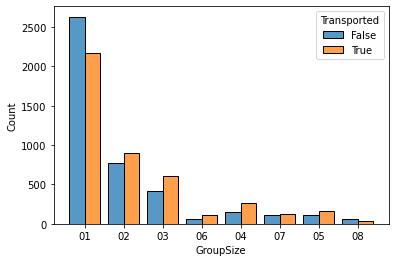

In [11]:
sns.histplot(data=train_data, x='GroupSize', hue='Transported', multiple='dodge', shrink=.8);

Salvo en grupos de tamaño 1 y 8, en el resto de grupos hay más pasajeros perdidos que no transportados.

## HomePlanet

The planet the passenger departed from, typically their planet of permanent residence.

In [15]:
train_data.HomePlanet.value_counts(dropna=False)

Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64

In [18]:
train_data.HomePlanet.fillna("Ns/Nc", inplace=True)

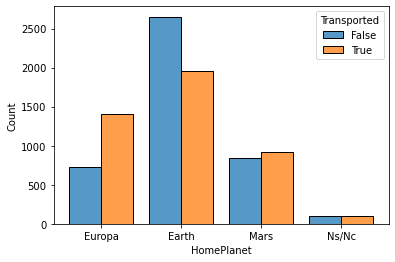

In [19]:
sns.histplot(train_data, x='HomePlanet', hue='Transported', multiple='dodge', shrink=.8);

Solo entre los pasajeros provenientes de la Tierra hay menos cantidad de pasajeros que se pierden.

## CryoSleep

Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.